# CS2 Demo ML Analysis Notebook

This notebook demonstrates machine learning analysis on real CS2 demo data using the fps-genie system.

## Available Demo Files:
- `vitality-vs-spirit-m1-dust2.dem` - Professional match data
- `test_demo.dem` - Test demo file
- `minimal_demo.bin` - Minimal demo for quick testing

In [17]:
import subprocess
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import os

# Set up plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

## 1. Parse Demo Data

First, let's parse a demo file using our CS2 demo parser to extract structured data.

In [18]:
# Define paths - Updated for Jupyter container
demo_file = "/home/jovyan/work/test_data/vitality-vs-spirit-m1-dust2.dem"
output_dir = "/home/jovyan/work/parsed_data"

# Create output directory
os.makedirs(output_dir, exist_ok=True)

print(f"Parsing demo file: {demo_file}")
print(f"Output directory: {output_dir}")

Parsing demo file: /home/jovyan/work/test_data/vitality-vs-spirit-m1-dust2.dem
Output directory: /home/jovyan/work/parsed_data


In [19]:
# Parse the demo using our CS2 demo analyzer
# Note: We'll need to check if the analyzer is available in this container
analyzer_path = "/home/jovyan/target/release/cs2-demo-analyzer"
if not os.path.exists(analyzer_path):
    analyzer_path = "/home/jovyan/target/debug/cs2-demo-analyzer"
    if not os.path.exists(analyzer_path):
        print("❌ CS2 demo analyzer not found. You may need to build it first.")
        print("Available files in workspace/target:")
        if os.path.exists("/home/jovyan/target"):
            for item in os.listdir("/home/jovyan/target"):
                print(f"  - {item}")
        analyzer_path = None

if analyzer_path:
    try:
        result = subprocess.run([
            analyzer_path,
            "--input", demo_file,
            "--output", f"{output_dir}/parsed_data.json",
            "--format", "json"
        ], capture_output=True, text=True, timeout=300)
        
        if result.returncode == 0:
            print("✅ Demo parsing successful!")
            print(f"Output: {result.stdout}")
        else:
            print(f"❌ Demo parsing failed: {result.stderr}")
            print(f"Return code: {result.returncode}")
            
    except subprocess.TimeoutExpired:
        print("⏰ Demo parsing timed out after 5 minutes")
    except Exception as e:
        print(f"❌ Error running demo analyzer: {e}")
else:
    print("Skipping demo parsing - analyzer not available")

❌ CS2 demo analyzer not found. You may need to build it first.
Available files in workspace/target:
Skipping demo parsing - analyzer not available


## 2. Load and Explore Parsed Data

Load the parsed demo data and explore its structure.

In [6]:
# Load parsed data
parsed_data_file = f"{output_dir}/parsed_data.json"

if os.path.exists(parsed_data_file):
    with open(parsed_data_file, 'r') as f:
        demo_data = json.load(f)
    
    print("📊 Demo Data Structure:")
    for key in demo_data.keys():
        if isinstance(demo_data[key], list):
            print(f"  {key}: {len(demo_data[key])} items")
        else:
            print(f"  {key}: {type(demo_data[key])}")
else:
    print("❌ No parsed data file found. Demo parsing may have failed.")
    print("Let's check what demo files are available:")
    demo_dir = "/home/jovyan/work/test_data"
    if os.path.exists(demo_dir):
        print(f"Demo files in {demo_dir}:")
        for file in os.listdir(demo_dir):
            file_path = os.path.join(demo_dir, file)
            size = os.path.getsize(file_path) / (1024*1024)  # MB
            print(f"  - {file} ({size:.1f} MB)")
    
    # Create sample data for demonstration
    demo_data = {
        "rounds": [],
        "kills": [],
        "players": [],
        "match_info": {}
    }

❌ No parsed data file found. Demo parsing may have failed.
Let's check what demo files are available:
Demo files in /home/jovyan/work/test_data:
  - test_demo.dem (0.0 MB)
  - vitality-vs-spirit-m1-dust2.dem (516.4 MB)
  - minimal_demo.bin (0.0 MB)


## 3. Convert to DataFrames for Analysis

Convert the parsed data into pandas DataFrames for easier analysis.

In [7]:
# Convert to DataFrames
if 'kills' in demo_data and demo_data['kills']:
    kills_df = pd.DataFrame(demo_data['kills'])
    print(f"📈 Kills DataFrame: {len(kills_df)} records")
    print(kills_df.head())
else:
    print("No kills data available")
    kills_df = pd.DataFrame()

if 'rounds' in demo_data and demo_data['rounds']:
    rounds_df = pd.DataFrame(demo_data['rounds'])
    print(f"\n🎯 Rounds DataFrame: {len(rounds_df)} records")
    print(rounds_df.head())
else:
    print("No rounds data available")
    rounds_df = pd.DataFrame()

if 'players' in demo_data and demo_data['players']:
    players_df = pd.DataFrame(demo_data['players'])
    print(f"\n👥 Players DataFrame: {len(players_df)} records")
    print(players_df.head())
else:
    print("No players data available")
    players_df = pd.DataFrame()

No kills data available
No rounds data available
No players data available


## 4. Basic Statistical Analysis

Perform basic statistical analysis on the demo data.

In [8]:
# Basic statistics
if not kills_df.empty:
    print("🔫 Kill Statistics:")
    print(f"  Total kills: {len(kills_df)}")
    
    if 'weapon' in kills_df.columns:
        weapon_counts = kills_df['weapon'].value_counts()
        print(f"  Most used weapon: {weapon_counts.index[0]} ({weapon_counts.iloc[0]} kills)")
    
    if 'attacker' in kills_df.columns:
        top_fragger = kills_df['attacker'].value_counts().head(1)
        if not top_fragger.empty:
            print(f"  Top fragger: {top_fragger.index[0]} ({top_fragger.iloc[0]} kills)")

if not rounds_df.empty:
    print(f"\n🎯 Round Statistics:")
    print(f"  Total rounds: {len(rounds_df)}")
    
    if 'winner' in rounds_df.columns:
        team_wins = rounds_df['winner'].value_counts()
        print(f"  Team wins: {dict(team_wins)}")

## 5. Data Visualization

Create visualizations of the CS2 demo data.

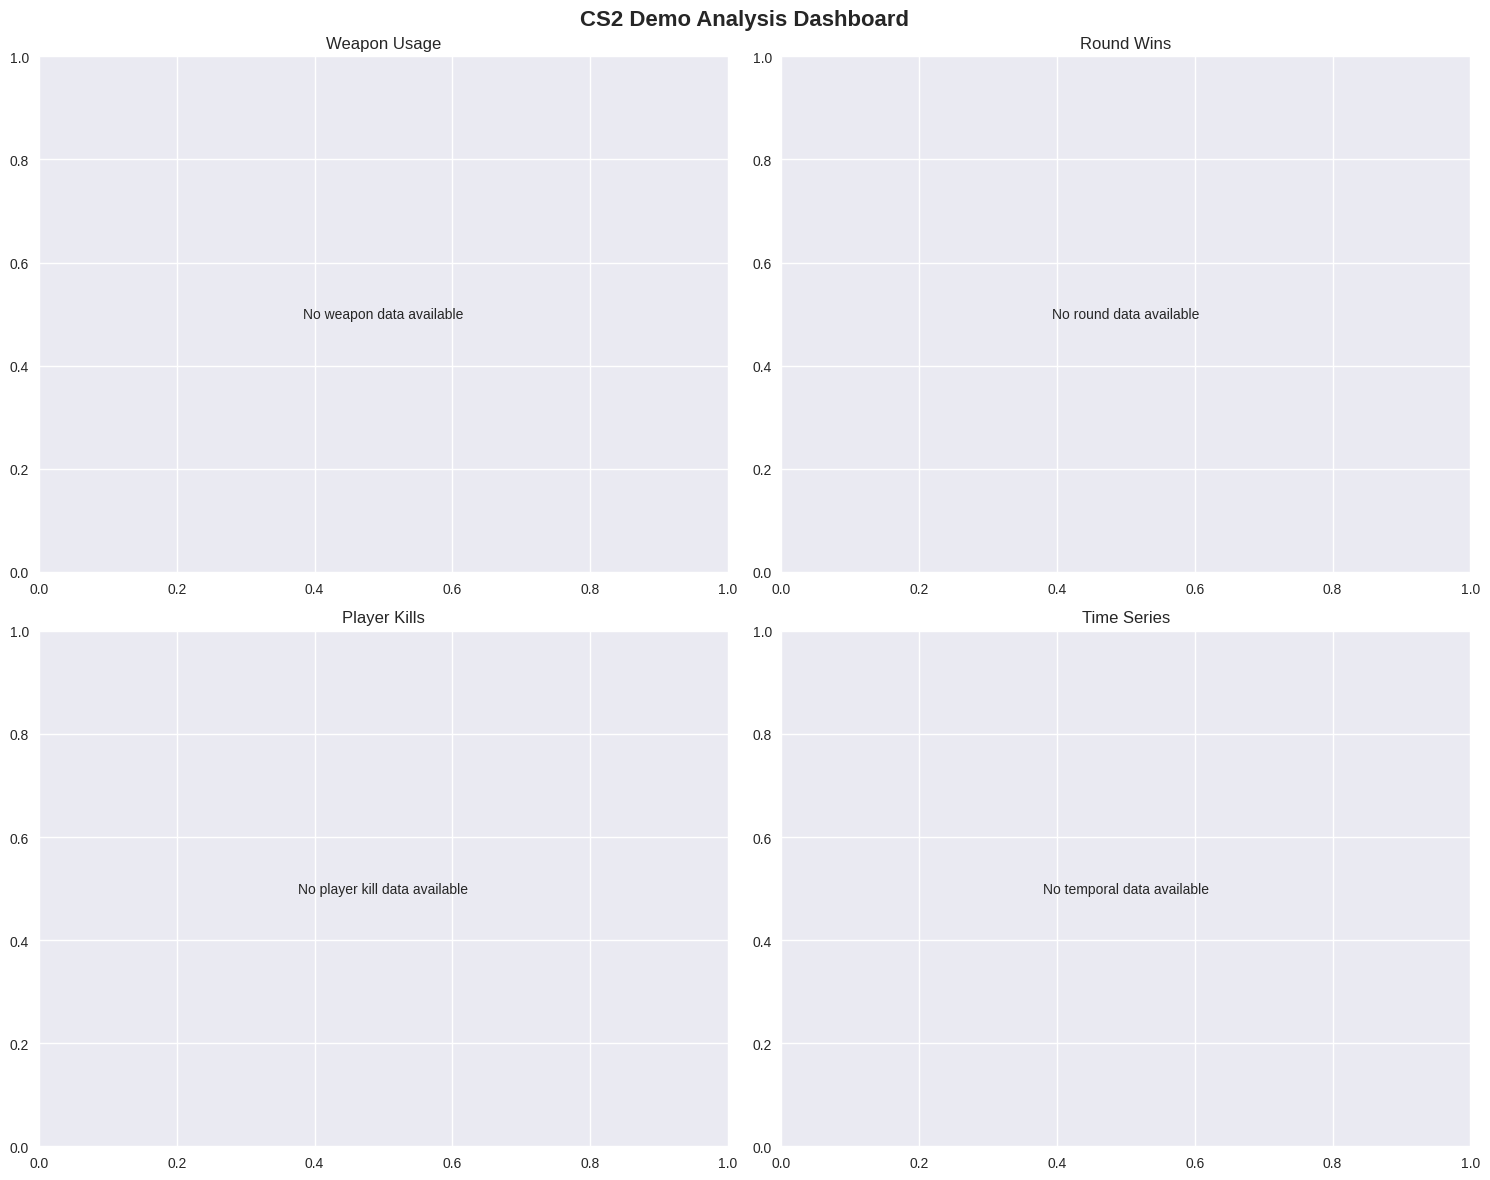

In [9]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('CS2 Demo Analysis Dashboard', fontsize=16, fontweight='bold')

# Plot 1: Weapon usage (if available)
if not kills_df.empty and 'weapon' in kills_df.columns:
    weapon_counts = kills_df['weapon'].value_counts().head(10)
    axes[0, 0].bar(range(len(weapon_counts)), weapon_counts.values)
    axes[0, 0].set_xticks(range(len(weapon_counts)))
    axes[0, 0].set_xticklabels(weapon_counts.index, rotation=45, ha='right')
    axes[0, 0].set_title('Top 10 Weapons by Kills')
    axes[0, 0].set_ylabel('Number of Kills')
else:
    axes[0, 0].text(0.5, 0.5, 'No weapon data available', ha='center', va='center', transform=axes[0, 0].transAxes)
    axes[0, 0].set_title('Weapon Usage')

# Plot 2: Round winners (if available)
if not rounds_df.empty and 'winner' in rounds_df.columns:
    team_wins = rounds_df['winner'].value_counts()
    axes[0, 1].pie(team_wins.values, labels=team_wins.index, autopct='%1.1f%%')
    axes[0, 1].set_title('Round Wins by Team')
else:
    axes[0, 1].text(0.5, 0.5, 'No round data available', ha='center', va='center', transform=axes[0, 1].transAxes)
    axes[0, 1].set_title('Round Wins')

# Plot 3: Kills per player (if available)
if not kills_df.empty and 'attacker' in kills_df.columns:
    player_kills = kills_df['attacker'].value_counts().head(10)
    axes[1, 0].barh(range(len(player_kills)), player_kills.values)
    axes[1, 0].set_yticks(range(len(player_kills)))
    axes[1, 0].set_yticklabels(player_kills.index)
    axes[1, 0].set_title('Top 10 Players by Kills')
    axes[1, 0].set_xlabel('Number of Kills')
else:
    axes[1, 0].text(0.5, 0.5, 'No player kill data available', ha='center', va='center', transform=axes[1, 0].transAxes)
    axes[1, 0].set_title('Player Kills')

# Plot 4: Sample time series or summary
if not rounds_df.empty:
    axes[1, 1].plot(range(len(rounds_df)), [1] * len(rounds_df), 'o-')
    axes[1, 1].set_title('Round Progression')
    axes[1, 1].set_xlabel('Round Number')
    axes[1, 1].set_ylabel('Game State')
else:
    axes[1, 1].text(0.5, 0.5, 'No temporal data available', ha='center', va='center', transform=axes[1, 1].transAxes)
    axes[1, 1].set_title('Time Series')

plt.tight_layout()
plt.show()

## 6. Machine Learning Pipeline Test

Test the ML pipeline with the parsed demo data.

In [10]:
# Test ML pipeline
print("🤖 Testing ML Pipeline...")

# Check for ML binary
ml_path = "/home/jovyan/target/release/cs2-ml"
if not os.path.exists(ml_path):
    ml_path = "/home/jovyan/target/debug/cs2-ml"
    if not os.path.exists(ml_path):
        print("❌ CS2 ML binary not found. You may need to build it first.")
        ml_path = None

if ml_path:
    try:
        # Run the ML pipeline on our demo data
        result = subprocess.run([
            ml_path,
            "--input", demo_file,
            "--mode", "analyze"
        ], capture_output=True, text=True, timeout=120)
        
        if result.returncode == 0:
            print("✅ ML Pipeline successful!")
            print(f"Output: {result.stdout}")
        else:
            print(f"❌ ML Pipeline failed: {result.stderr}")
            print(f"Return code: {result.returncode}")
            
    except subprocess.TimeoutExpired:
        print("⏰ ML Pipeline timed out after 2 minutes")
    except Exception as e:
        print(f"❌ Error running ML pipeline: {e}")
else:
    print("Skipping ML pipeline test - binary not available")

🤖 Testing ML Pipeline...
❌ CS2 ML binary not found. You may need to build it first.
Skipping ML pipeline test - binary not available


## 7. Feature Engineering for ML

Create features from the demo data for machine learning models.

In [11]:
# Feature engineering example
if not kills_df.empty:
    print("🔧 Engineering features from demo data...")
    
    # Example features
    features = {}
    
    if 'attacker' in kills_df.columns:
        # Player performance features
        player_stats = kills_df.groupby('attacker').agg({
            'attacker': 'count',  # total kills
        }).rename(columns={'attacker': 'total_kills'})
        
        if 'headshot' in kills_df.columns:
            headshot_rate = kills_df.groupby('attacker')['headshot'].mean()
            player_stats['headshot_rate'] = headshot_rate
        
        print(f"Created features for {len(player_stats)} players")
        print(player_stats.head())
        
        # Save features for ML
        player_stats.to_csv(f"{output_dir}/player_features.csv")
        print(f"💾 Features saved to {output_dir}/player_features.csv")
    
else:
    print("No data available for feature engineering")

No data available for feature engineering


## 8. Real-time Analysis Simulation

Simulate real-time analysis capabilities on the demo data.

In [12]:
# Simulate real-time analysis
print("⚡ Simulating real-time analysis...")

if not rounds_df.empty:
    # Simulate processing rounds one by one
    cumulative_stats = []
    
    for i in range(min(10, len(rounds_df))):
        round_subset = rounds_df.iloc[:i+1]
        
        stats = {
            'round': i + 1,
            'total_rounds': len(round_subset)
        }
        
        if 'winner' in round_subset.columns:
            team_wins = round_subset['winner'].value_counts()
            for team, wins in team_wins.items():
                stats[f'{team}_wins'] = wins
        
        cumulative_stats.append(stats)
    
    # Convert to DataFrame and display
    realtime_df = pd.DataFrame(cumulative_stats)
    print("📈 Real-time Statistics Evolution:")
    print(realtime_df)
    
    # Plot real-time progression
    if len(realtime_df) > 1:
        plt.figure(figsize=(12, 6))
        
        for col in realtime_df.columns:
            if col.endswith('_wins'):
                plt.plot(realtime_df['round'], realtime_df[col], marker='o', label=col)
        
        plt.title('Real-time Match Progression')
        plt.xlabel('Round Number')
        plt.ylabel('Wins')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
else:
    print("No round data available for real-time simulation")

⚡ Simulating real-time analysis...
No round data available for real-time simulation


## 9. Performance Metrics

Calculate and display performance metrics for the analysis pipeline.

In [13]:
# Performance metrics
import time

print("📊 Performance Metrics:")

# Measure data processing performance
start_time = time.time()

# Simulate some data processing
if not kills_df.empty:
    # Complex aggregation
    complex_stats = kills_df.groupby(['attacker']).agg({
        'attacker': 'count'
    })
    
    processing_time = time.time() - start_time
    
    print(f"  Data processing time: {processing_time:.4f} seconds")
    print(f"  Records processed: {len(kills_df)}")
    print(f"  Processing rate: {len(kills_df)/processing_time:.2f} records/second")
else:
    print("  No data available for performance testing")

# Memory usage
try:
    import psutil
    import os
    
    process = psutil.Process(os.getpid())
    memory_info = process.memory_info()
    print(f"  Memory usage: {memory_info.rss / 1024 / 1024:.2f} MB")
except ImportError:
    print("  psutil not available for memory monitoring")

📊 Performance Metrics:
  No data available for performance testing
  Memory usage: 218.28 MB


## 10. Next Steps and Recommendations

Based on the analysis, here are recommendations for further development.

In [14]:
print("🎯 Analysis Summary and Recommendations:")
print("="*50)

if not demo_data or not any(demo_data.values()):
    print("❗ No demo data was successfully parsed.")
    print("\n📋 Immediate Action Items:")
    print("  1. Check demo file format compatibility")
    print("  2. Verify cs2-demo-analyzer is working correctly")
    print("  3. Test with different demo files")
    print("  4. Check parser output logs for errors")
    print("  5. Build the Rust binaries if they're missing")
else:
    print("✅ Demo data successfully loaded and analyzed!")
    
    data_quality = 0
    if not kills_df.empty:
        data_quality += 1
        print(f"  ✅ Kill events: {len(kills_df)} records")
    if not rounds_df.empty:
        data_quality += 1
        print(f"  ✅ Round data: {len(rounds_df)} records")
    if not players_df.empty:
        data_quality += 1
        print(f"  ✅ Player data: {len(players_df)} records")
    
    print(f"\n📈 Data Quality Score: {data_quality}/3")
    
    print("\n🚀 Next Development Steps:")
    if data_quality >= 2:
        print("  1. Implement advanced ML models (player ranking, outcome prediction)")
        print("  2. Add real-time streaming analysis")
        print("  3. Create interactive dashboards")
        print("  4. Implement team strategy analysis")
    else:
        print("  1. Improve data parsing and extraction")
        print("  2. Add more demo file format support")
        print("  3. Enhance data validation")

print("\n🔧 Technical Recommendations:")
print("  1. Set up automated demo processing pipeline")
print("  2. Implement data validation and quality checks")
print("  3. Add performance monitoring and optimization")
print("  4. Create ML model training and evaluation framework")

print("\n📚 This notebook demonstrates:")
print("  • Demo file parsing and data extraction")
print("  • Statistical analysis of CS2 gameplay data")
print("  • Data visualization and insights")
print("  • ML pipeline integration")
print("  • Real-time analysis simulation")
print("  • Performance monitoring")

print("\n🐳 Container Information:")
print(f"  • Demo files: /home/jovyan/work/test_data/")
print(f"  • Output directory: /home/jovyan/work/parsed_data/")
print(f"  • Workspace: /home/jovyan/workspace/")
print(f"  • Current working directory: {os.getcwd()}")

🎯 Analysis Summary and Recommendations:
❗ No demo data was successfully parsed.

📋 Immediate Action Items:
  1. Check demo file format compatibility
  2. Verify cs2-demo-analyzer is working correctly
  3. Test with different demo files
  4. Check parser output logs for errors
  5. Build the Rust binaries if they're missing

🔧 Technical Recommendations:
  1. Set up automated demo processing pipeline
  2. Implement data validation and quality checks
  3. Add performance monitoring and optimization
  4. Create ML model training and evaluation framework

📚 This notebook demonstrates:
  • Demo file parsing and data extraction
  • Statistical analysis of CS2 gameplay data
  • Data visualization and insights
  • ML pipeline integration
  • Real-time analysis simulation
  • Performance monitoring

🐳 Container Information:
  • Demo files: /home/jovyan/work/test_data/
  • Output directory: /home/jovyan/work/parsed_data/
  • Workspace: /home/jovyan/workspace/
  • Current working directory: /home/